Please download the datasets from here: https://drive.google.com/open?id=1mNEblJS0622w5-2mB6yCyMbu7RbcfENL<br>
This should contain the following:
- __5_min_train__: training data as np array. Shape: (7500, 64, 64, 8)
- __5_min_xval__: validation data (currently unused) as np array. Shape: (1500, 64, 64, 8)
- __5_min_test__: test data (used as visual validation during training) as np array. Shape: (1000, 64, 64, 8)
- __5_min_norms__: list of floats containing the maximum pixel intensity value prior to normalization for each sequence. Shape: (10000,)
- __5_min_long_pred__: test data for sequence prediction as np array. We used it for testing after training. Shape: (1000, 64, 64, 20)
- __5_min_long_pred_norms__: list of floats containing the maximum pixel intensity value prior to normalization for each sequence for the 5_min_long_pred dataset. Shape: (1000,)
- __tgan_1/2/4-1_vx/vy_2000__: optical flow images between the last and second last frames of the input for the first 2000 sequences of the training dataset (__5_min_train__) as np array. The 1/2/4 means the length of the input sequence. We mostly used 2. Shape: (2000, 64, 64, 1)
- __germany__: Not needed. (GPS coordinates of Germany. Used for experimenting before.)

In the datasets the first axis is stands for the sample, the next two for the frame height and width and the last for the channels which is the time axis here.<br>
If data is missing or you cannot acces the drive, please write me an E-Mail: pkicsiny@gmail.com

In [25]:
import src
import keras.backend as K
import os
import numpy as np
import sys
from scipy import ndimage
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#models folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/models/')
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3601472183934175717
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10288516132518590762
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


Some general parameters.

In [4]:
past = 2
name = f"tgan_{past}-1"
batch_size=64
iterations = 5000
#generator trainings in 1 iter
g = 2
#spatial disc trainings in 1 iter
s = 1
#temporal disc trainings in 1 iter
t = 1
#initialize random seed
RND = 777
np.random.seed(RND)

In [5]:
#set this to true if you want to use a pretrained model and load its weights from file
use_loaded = True

## Build network

Make generator but don't compile.

In [6]:
generator = src.unet((64, 64, past), dropout=0, batchnorm=True, kernel_size=4, feature_mult=1) #ks 5 for load model

Make discriminators and don't compile.

In [7]:
s_discriminator = src.spatial_discriminator(condition_shape=(64, 64, past), dropout = 0.5, batchnorm=True)
t_discriminator = src.temporal_discriminator(dropout = 0.5, batchnorm=True)

Inputs and outputs of the GAN.

In [8]:
frame_t = keras.layers.Input(shape=(64, 64, past))
adv = keras.layers.Input(shape=(64, 64, 1))

In [9]:
generated = generator(frame_t)
s_score = s_discriminator([frame_t, generated])
t_score = t_discriminator([adv, generated])

Loss weights.

In [10]:
loss_weights=[0.3, 1, 1]

Make combined model.

In [11]:
combined = keras.models.Model(inputs=[frame_t, adv], outputs=[generated, s_score, t_score])

Compile discriminators with trainable weights.

In [12]:
s_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])
t_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

Freeze discriminator weights and compile combined GAN with only the generator trainable.

In [13]:
s_discriminator.trainable = False
t_discriminator.trainable = False
combined.compile(loss=[src.custom_loss(loss="l1"),
                       keras.losses.binary_crossentropy,
                       keras.losses.binary_crossentropy],
                 optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights,
                 metrics=[src.relative_error_tensor, "accuracy", "accuracy"])

***Using L1 loss.***
Tensor("metrics_2/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("model_1_target:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("metrics_2/relative_error_tensor_1/truediv:0", shape=(), dtype=float32)
Tensor("model_2_target:0", shape=(?, ?), dtype=float32)
Tensor("metrics_2/relative_error_tensor_2/truediv:0", shape=(), dtype=float32)
Tensor("model_3_target:0", shape=(?, ?), dtype=float32)


If there is a pretrained model load and use its weights. Also set discriminator weights to trainable then recompile model.

In [14]:
if use_loaded:
    combined.load_weights(sys.path[1]+name+"/"+name+"_model.h5")
    generator = combined.layers[1]
    s_discriminator = combined.layers[3]
    s_discriminator.trainable = True
    for l in s_discriminator.layers: l.trainable = True
    t_discriminator = combined.layers[4]
    t_discriminator.trainable = True
    for l in t_discriminator.layers: l.trainable = True
    s_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])
    t_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])
    s_discriminator.trainable = False
    t_discriminator.trainable = False
    combined.compile(loss=[src.custom_loss(loss="l1"),
                       keras.losses.binary_crossentropy,
                       keras.losses.binary_crossentropy],
                     optimizer=keras.optimizers.Adam(0.0002, 0.5),
                     loss_weights=loss_weights,
                     metrics=[src.relative_error_tensor, "accuracy", "accuracy"])

***Using L1 loss.***
Tensor("metrics_5/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("model_1_target_1:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("metrics_5/relative_error_tensor_1/truediv:0", shape=(), dtype=float32)
Tensor("model_2_target_1:0", shape=(?, ?), dtype=float32)
Tensor("metrics_5/relative_error_tensor_2/truediv:0", shape=(), dtype=float32)
Tensor("model_3_target_1:0", shape=(?, ?), dtype=float32)


If you are using loaded weights for prediction only then please skip to the __prediction__ section.

## Load dataset

In [ ]:
#past+1 is bc of temporal raining. See second presentation.
train, xval, test = src.load_datasets(past_frames=past+1)

Split data to inputs and ground truth images. Does data augmentation by rotations. Uses the first 2000 samples (bc. of memory issue.)

In [ ]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past+1, augment=True)

Calculate optical flows between frame t-1 and t.

In [ ]:
#optical flow of the augmented data of the first 2000 training images (8000 images)
#vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2, init=1) # (n,:,:,1)

Save optical flows

In [ ]:
#np.savez_compressed(f"{name}_vx_2000",vx) #2000 denotes that they re the flo2 of the first 2000 samples from the training dataset
#np.savez_compressed(f"{name}_vy_2000",vy)

If optical flows are saved, load them

In [ ]:
vx = np.load(sys.path[0]+f"/{name}_vx_2000.npz")["arr_0"]
vy = np.load(sys.path[0]+f"/{name}_vy_2000.npz")["arr_0"]

Preprocess optical flows

In [ ]:
normalized_optical_flow = src.normalize_flows(vx, vy)
flows = np.transpose([[ndimage.median_filter(image[..., ch], 4) for ch in range(2)] for image in normalized_optical_flow], (0, 2, 3, 1))

Make discriminator labels.

In [ ]:
# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

Switch 5% of labels and smooth from 1 to 0.9.

In [ ]:
#real, fake = src.noisy_d_labels(real, fake)

Log dict. Either append to existing log or start with an empty one.

In [ ]:
#nb_batches = int(gan_train.shape[0] / batch_size)

if use_loaded:
    log = np.load(sys.path[1]+name+"/"+name+"_log.npy").item()
else:
    log = {"g_loss":[],
           "d_loss":[],
           "ds_loss":[],
           "dt_loss":[],
           "g_metric":[],
           "d_metric":[],
           "ds_metric":[],
           "dt_metric":[],
           "d_loss_real":[],
           "d_loss_fake":[],
           "ds_loss_real":[],
           "ds_loss_fake":[],
           "dt_loss_real":[],
           "dt_loss_fake":[],}

## Training

In [ ]:
for it in range(iterations):
#batch
#idx = range(it%nb_batches * batch_size,(it%nb_batches + 1) * batch_size)
#DS create training batch
    s_discriminator.trainable = True
    for tds in range(s):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        #predict next frame  
        generated_imgs = generator.predict(training_batch) 
        #train discriminator
        ds_loss_real = s_discriminator.train_on_batch([training_batch, real_imgs], real)
        ds_loss_fake = s_discriminator.train_on_batch([training_batch, generated_imgs], fake)
        #add losses
        ds_loss = 0.5 * np.add(ds_loss_real, ds_loss_fake)
    s_discriminator.trainable = False

#DT create training batch
    t_discriminator.trainable = True
    for tdt in range(t):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        
        #predict frame t from frame t-1 and advect
        aux_batch = gan_train[idx,:,:,:-1]
        
        advected_aux_gen = generator.predict(aux_batch)
        advected_aux_truth = training_batch[:,:,:,-1:]
        for i in range(10):
            advected_aux_gen = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_gen, -flows[idx]), axis=-1)])
            advected_aux_truth = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_truth, -flows[idx]), axis=-1)])
     
        #predict next frame
        generated_imgs = generator.predict(training_batch) 
        #train discriminator
        dt_loss_real = t_discriminator.train_on_batch([advected_aux_truth, real_imgs], real)
        dt_loss_fake = t_discriminator.train_on_batch([advected_aux_gen, generated_imgs], fake)
        #add losses
        dt_loss = 0.5 * np.add(dt_loss_real, dt_loss_fake)
    t_discriminator.trainable = False
    
#Total discriminator loss
    d_loss = 0.5 * np.add(ds_loss, dt_loss)
    d_loss_real = 0.5 * np.add(ds_loss_real, dt_loss_real)
    d_loss_fake = 0.5 * np.add(ds_loss_fake, dt_loss_fake)
        

#Generator
    for tg in range(g):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        
        aux_batch = gan_train[idx,:,:,:-1]
        advected = generator.predict(aux_batch)
        for i in range(10):
            advected = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected, -flows[idx]), axis=-1)])
    
        g_loss = combined.train_on_batch([training_batch, advected], [real_imgs, real, real])
    
    log["g_loss"].append(g_loss)
    log["d_loss"].append(d_loss)
    log["ds_loss"].append(ds_loss[0])  
    log["dt_loss"].append(dt_loss[0])
    log["g_metric"].append(g_loss[1])
    log["d_metric"].append(d_loss[1])
    log["ds_metric"].append(ds_loss[1])
    log["dt_metric"].append(dt_loss[1])
    log["d_loss_real"].append(d_loss_real)
    log["d_loss_fake"].append(d_loss_fake)
    log["ds_loss_real"].append(ds_loss_real)
    log["ds_loss_fake"].append(ds_loss_fake)
    log["dt_loss_real"].append(dt_loss_real)
    log["dt_loss_fake"].append(dt_loss_fake)
    
    
    print(f"\033[1m {it} [Ds loss: {ds_loss[0]}, acc.: {100*ds_loss[1]}]\033[0m \n"+
          f"\033[1m {it} [Dt loss: {dt_loss[0]}, acc.: {100*dt_loss[1]}]\033[0m \n"+
          f"\033[1m {it} [G loss: {g_loss[0]}, G obj.: {g_loss[1]}, Gs bce.: {g_loss[2]}, Gt bce.: {g_loss[3]}]\033[0m")
    print(f"S: real loss: {ds_loss_real}, fake loss: {ds_loss_fake}")
    print(f"T: real loss: {dt_loss_real}, fake loss: {dt_loss_fake}")
    
    if it in [499, 999]:  
        loss_weights[0] -= 0.1
        print(f"L1 loss decreased. New weight: {loss_weights[0]}")
        combined.compile(loss=[src.custom_loss(loss="l1"),
                       keras.losses.binary_crossentropy,
                       keras.losses.binary_crossentropy],
                 optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights,
                 metrics=[src.relative_error_tensor, "accuracy", "accuracy"])

src.sample_images(iterations, gan_test[...,1:], gan_test_truth, past, generator)
src.plot_temporal_training_curves(log, iterations, name)

Save model history

In [ ]:
np.save(name+"_log",log)

Save model weights

In [ ]:
combined.save_weights(name+"_model.h5")

## Prediction

Loads a 20 long sequence with 1000 sequence samples.

In [15]:
sequence_test = src.load_datasets(prediction=True)
#sequence_test = src.augment_data(sequence_test[:100])

Test data: (1000, 64, 64, 20)


In [16]:
generator = combined.layers[1]

Iteratively predict next 5 frames (25 mins into the future).

In [17]:
n_next = 4
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]
for t in range(n_next):
    src.update_output(t)
    future = generator.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

3


Save example predictions

In [ ]:
src.sequence_prediction_plot(name, sequence_test, predictions, past, samples=[33,67])

Renormalize intensity values

In [18]:
test_norms = np.load(sys.path[0]+"/5min_long_pred_norms_compressed.npz")["arr_1"]

In [19]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in list(map(str,np.arange(0,n_next)))])[:,:,:,:,0]), (1,2,3,0))

Calculate pixel intensities back to dBZ and from there to mm/h. <br>
Sources: <br>
- https://www.dwd.de/DE/leistungen/radolan/radolan_info/radolan_radvor_op_komposit_format_pdf.pdf?__blob=publicationFile&v=11 (page 10)
- <https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates>

In [20]:
#dBZ
dBZ_t = renormalized_test*0.5 - 32.5
dBZ_p = renormalized_predictions*0.5 - 32.5
#mm/h
I_t = (0.005*10**(0.1*dBZ_t))**(0.625)
I_p = (0.005*10**(0.1*dBZ_p))**(0.625)

Calculate scores

In [ ]:
intensity_scores = src.get_scores(renormalized_predictions, renormalized_test, n_next, past, thresholds_as_list=[18])
scores = src.get_scores(I_p, I_t, n_next, past, thresholds_as_list=[0.5])

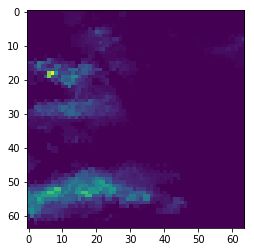

In [30]:
plt.imshow(I_t[100,...,0])

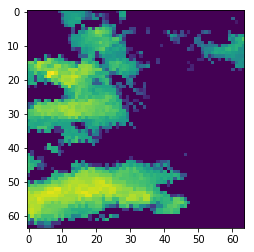

In [31]:
plt.imshow(renormalized_test[100,...,0])

Save scores.

In [ ]:
np.save(name+"_scores",scores)
np.save(name+"_intensity_scores",intensity_scores)

In [ ]:
np.mean(scores["pred_1"]["corr_to_truth"])

In [ ]:
np.mean(intensity_scores["pred_1"]["corr_to_truth"])